# DBSCAN
1. 敘述性理解: 以密度為基礎的分群方式，用密度的概念剃除不屬於所有分群資料的雜訊點, 可是有個小問題, 例如: a, b很近, b, c很近, c, d很近, 最後a跟很遠的d變成了同一群, 必須要注意這一點特性, 因為他是"一直畫圓圈"去檢查是否可以同群的方式, 只要密度符合你設定的半徑就會一直延伸下去
2. 此演算法不難, 維基有pseudocode, https://en.wikipedia.org/wiki/DBSCAN
3. 非監督學習, 給定半徑ep, 與群可接受的最小數量n, 因此可決定雜訊點, 群數可以自己偵測
4. 看官網範例, 對於每一點資料, 必須要做normalize (StandardScaler套件)
5. 3萬多筆的蘋果新聞分詞成高維度的矩陣, DBSCAN跑到12G ram都爆掉..., 才3萬多筆而以, 看來可能需要降維度, 又面臨失真問題, 看來目前k-means比較好一點, 雖然要事先決定群數, 但是目前也有 Average Silhouette Width 可以偵測群數, 這是sklearn的例子 =>http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
6. 用途: 偵測密度會比較適合, 沒有區域性, 不會受群組的形狀影響

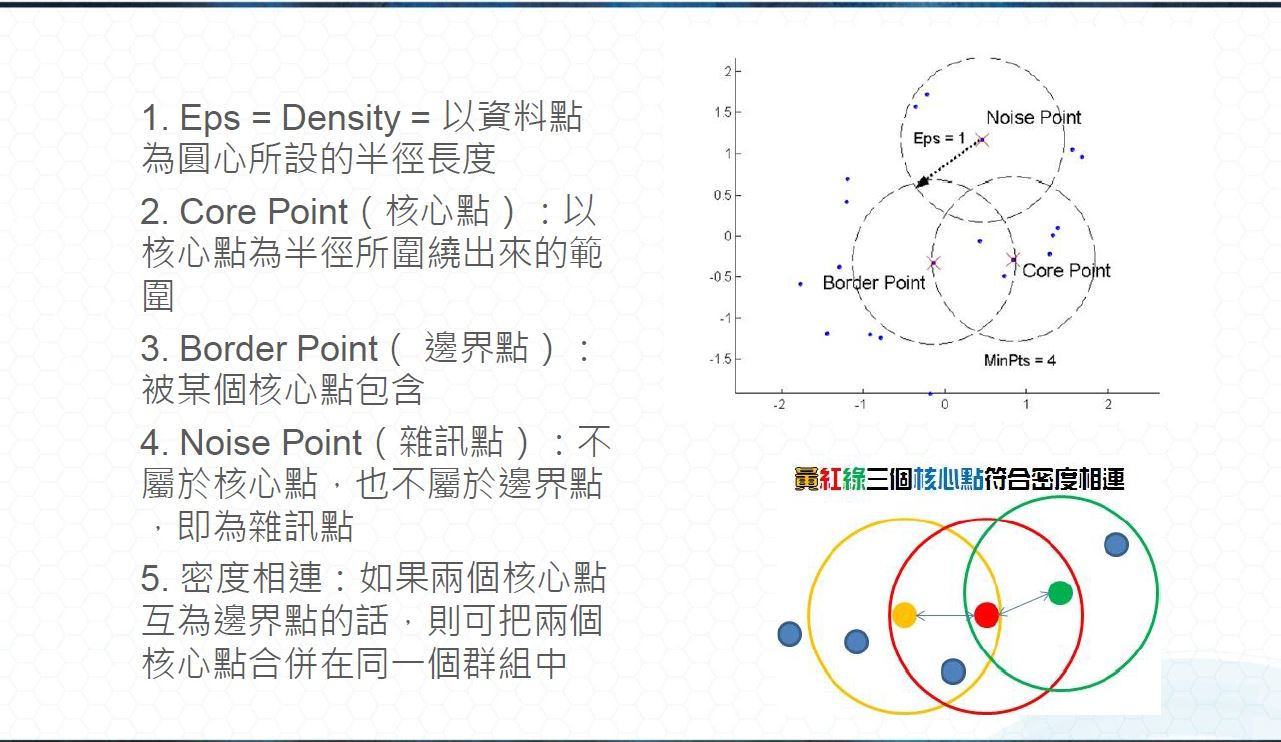

In [3]:
from IPython.display import Image
Image('dbscan.jpg')

In [3]:
%reset -f
%pylab inline
import sys, codecs, pandas as pd, numpy as np, os, re, traceback, pprint, sqlite3, importlib
import jieba, jieba.analyse
from __future__ import division, unicode_literals, with_statement, print_function
from sklearn import datasets
from contextlib import closing

rootPath = 'D:/Gary/WinPython/WinPython-64bit-2.7.10.3/notebooks'

class DataSources(object):    
    def sklearnDs(self):
        return sqlite3.connect(rootPath + '/sklearnDs.sqlite')

    def t1nscp(self):
        oraClient = 'D:/Gary/instantclient_11_1_x64'
        nlsLang = 'AMERICAN_AMERICA.UTF8'
        oracle = loader.loadOracle(oraClient, nlsLang)
        conf = pd.Series(dict(
            user='basman',
            password='MANUser0617',
            host='172.16.32.196',
            port='7540',
            sid='T1NSCP'
        ))
        return oracle.connect(conf.user, conf.password, oracle.makedsn(conf.host, conf.port, conf.sid))

ds = DataSources()

Populating the interactive namespace from numpy and matplotlib


In [4]:
# 抓出頻果新聞資料
apple78Df = None
with closing(ds.sklearnDs()) as sklearnConn:
    apple78Df = pd.read_sql('''
        select forum, subject, term, keyword, content, pageurl
          from tb_apple_20160701_20160823_02
         order by batchno
    ''', sklearnConn)
apple78Df.head(10)

,forum,subject,term,keyword,content,pageurl
0,politics,軍人虐狗 國防部長上莒光園地：絕不容許再發生,更新 影片 海軍陸戰隊 事件 國防部長 馮世寬 火線 道歉 莒光 馮世寬 官兵 殘忍 國軍 ...,馮世寬 馮世寬 馮世寬 馮世寬 馮世寬 生命 生命 生命 生命 生命 官兵 官兵 官兵 衛國...,（更新：新增影片） 海軍陸戰隊虐狗事件引發眾怒，國防部長馮世寬不但親上火線道歉，今天「莒光園...,http://www.appledaily.com.tw/realtimenews/arti...
1,entertainment,田馥甄舉杯慶《日常》 佼佼：小心變張清芳,新聞 田馥甄 Hebe 記者會 現場 斯洛伐克 家居 模樣 日常生活 專輯 日常 曲目 曝光...,田馥甄 田馥甄 田馥甄 田馥甄 專輯 專輯 專輯 專輯 專輯 日常生活 日常生活 日常生活 ...,(新增動新聞) 田馥甄（Hebe）今舉辦發片記者會，現場打造斯洛伐克家居模樣，展現出她的日常...,http://www.appledaily.com.tw/realtimenews/arti...
2,fashion,Rimowa聯名蕭青陽騎白馬 徐佳瑩歌聲助陣,新聞 德國 行李箱 品牌 發表 台灣 設計師 青陽 合作 台灣 青陽 作品 白馬 靈感 設計...,青陽 青陽 青陽 青陽 青陽 青陽 青陽 青陽 徐佳瑩 徐佳瑩 徐佳瑩 白馬 白馬 白馬 作...,（新增動新聞） 德國知名行李箱品牌Rimowa，發表首次與台灣設計師蕭青陽合作的台灣獨賣限定...,http://www.appledaily.com.tw/realtimenews/arti...
3,fashion,【女神進化】天心戴蛇形陀飛輪錶 許願升級魅惑術,新聞 天心 金融業 男友 分手 寶格麗 BVLGARI 發表 珠寶 許願 個性 女人 學習 ...,serpenti serpenti serpenti serpenti serpenti s...,（新增動新聞）天心和金融業男友剛分手，今為寶格麗（BVLGARI）發表Serpenti新珠寶...,http://www.appledaily.com.tw/realtimenews/arti...
4,property,房仲6月交易價量 雙北市逆轉勝,影片 房仲 房市 交易 台灣 逆轉勝 永慶 房產 集團 中心 全台 房市 交易量 北市 桃園...,交易量 交易量 交易量 交易量 北市 北市 北市 北市 北市 台南 台南 台南 台南 房市 ...,(新增：影片) 各家房仲發布6月房市交易現況，出現北台灣「逆轉勝」。其中，永慶房產集團研展中...,http://www.appledaily.com.tw/realtimenews/arti...
5,sports,【強】王建民2局無失分 第5勝進帳,更新 更新 影片 比賽 皇家 終結者 戴維斯 Wade Davis 救援 延長 王建民 演出...,皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 王建民 ...,更新：新增球評說法 (更新影片)(更進比賽進度) 皇家終結者戴維斯(Wade Davis)本...,http://www.appledaily.com.tw/realtimenews/arti...
6,politics,巴拉圭農牧業者：希望高品質牛肉 供應台灣家庭,更新 影片 巴拉圭 鄉村 協會 時間 中午 款待 台灣 總統 蔡英文 巴拉圭 副總統 法拉 ...,巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉...,（更新：新增影片）巴拉圭鄉村協會在當地時間30日中午設宴款待台灣總統蔡英文，巴拉圭副總統艾法...,http://www.appledaily.com.tw/realtimenews/arti...
7,life,台北-台中天天通勤 高鐵哥告訴你真相,更新 影片 高鐵 生活 高鐵 天天 通勤 交通工具 網友 MOBILE01 台中 台北 天天...,高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 公司 公司 公司 公司 公司 公司 公司 公...,（更新：新增影片）高鐵可以達成各地生活一日圈，但問題是高鐵雖然快又方便，卻能當成「天天」通勤...,http://www.appledaily.com.tw/realtimenews/arti...
8,local,夜偷24斤生猛海鮮 門把留1枚指紋落網,更新 影像 影片 新北市 許姓 男子 清晨 金山區 台2線 海產 徒手 拉開 生鏽 欄杆 窗...,海產 海產 海產 海產 海產 金山區 金山區 指紋 指紋 許姓 許姓 黃酒 海螺 畫面 畫面...,(更新：增加內容、影像、影片)新北市30歲許姓男子，去年5月26日清晨5時許，見金山區台2線...,http://www.appledaily.com.tw/realtimenews/arti...
9,local,【專業文】分辨正港UA 專家有4招,更新 影片 智慧財產權 案件 刑事警察 大隊 高雄市 早市 攤商 仿冒 服飾 代理 隊長 蔡...,正品 正品 正品 正品 正品 正品 正品 正品 under under under unde...,（更新：新增影片）專責偵辦侵害智慧財產權案件的保二總隊刑事警察大隊，這次在高雄市區早市，查獲...,http://www.appledaily.com.tw/realtimenews/arti...


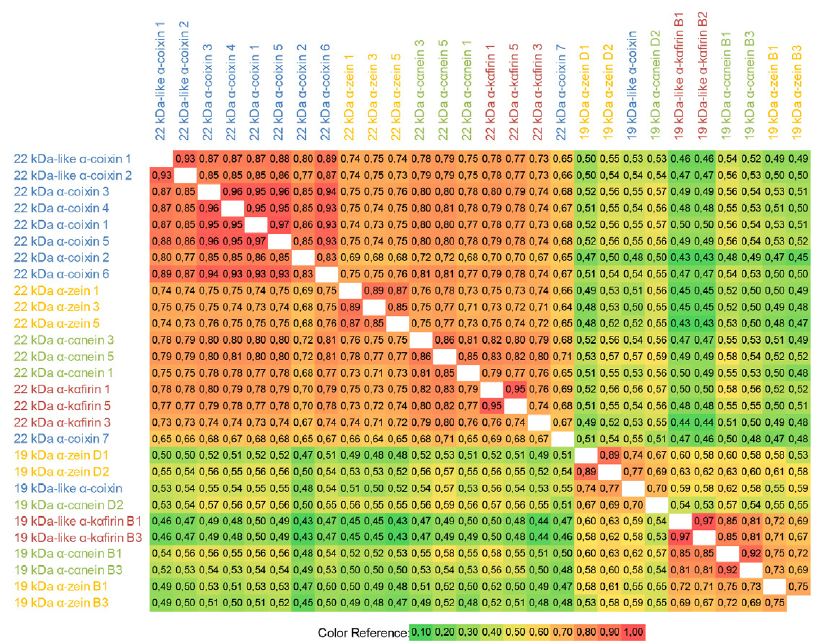

In [7]:
# 距離矩陣的資料格式
from IPython.display import Image
Image('distMx.png')

In [9]:
# 用是先計算好的cosine distance去算距離, 半徑給0.75(用觀察的), 可觀察出分幾群
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_distances

vec = TfidfVectorizer()
termMx = vec.fit_transform(apple78Df[:1000].term).toarray()
distMx = cosine_distances(termMx)
db = DBSCAN(eps=0.75, metric='precomputed', min_samples=5).fit(distMx)
pd.Series(db.labels_).value_counts()

-1     663
 8     118
 0      39
 13     35
 3      22
 6      11
 4      10
 5      10
 7      10
 10     10
 9       9
 12      8
 16      8
 14      6
 2       6
 11      5
 20      5
 15      5
 17      5
 18      5
 19      5
 1       5
dtype: int64

Estimated number of clusters: 21
Homogeneity: 0.259
Completeness: 0.415
V-measure: 0.319
Adjusted Rand Index: 0.050
Adjusted Mutual Information: 0.219
Silhouette Coefficient: -0.316


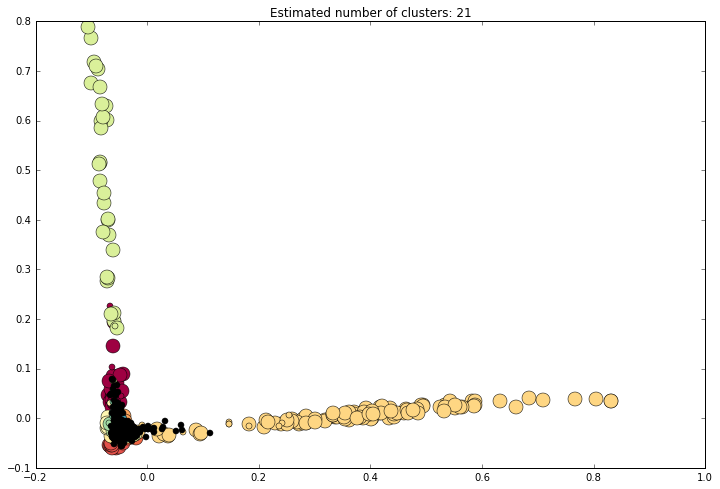

In [17]:
# 將圖型PCA降維度到2維之後視覺化 => 亂七八糟
# 看分數, 仍然只能搖搖頭

from sklearn import metrics
from sklearn.decomposition import PCA

labels_true = apple78Df.forum.values[:1000]
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# PCA降維度
pca = PCA(n_components=2)
X = pca.fit_transform(termMx)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

##############################################################################
# Plot result
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

# plt.xticks(np.linspace(-.2, .2, 10))    
# plt.yticks(np.linspace(-.1, .3, 10))

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [38]:
# np.set_printoptions(suppress=True, precision=7)
print(distMx.shape)
distMx

(1000L, 1000L)


array([[ 0.       ,  0.9776578,  0.9864524, ...,  0.9683767,  0.9750906,  0.9100855],
       [ 0.9776578,  0.       ,  0.9456471, ...,  0.9801487,  0.9932428,  0.9638602],
       [ 0.9864524,  0.9456471,  0.       , ...,  0.9945705,  0.995688 ,  0.9884977],
       ..., 
       [ 0.9683767,  0.9801487,  0.9945705, ...,  0.       ,  0.9658819,  0.8063164],
       [ 0.9750906,  0.9932428,  0.995688 , ...,  0.9658819, -0.       ,  0.9494843],
       [ 0.9100855,  0.9638602,  0.9884977, ...,  0.8063164,  0.9494843,  0.       ]])

In [21]:
# 觀察雜訊點
noiseDf = apple78Df[:1000][db.labels_ == -1]
print(noiseDf.forum.value_counts())
noiseDf

international    147
life             106
local             87
entertainment     71
finance           52
strange           40
forum             29
animal            26
3c                25
sports            22
fashion           21
politics          19
property          18
Name: forum, dtype: int64


,forum,subject,term,keyword,content,pageurl
0,politics,軍人虐狗 國防部長上莒光園地：絕不容許再發生,更新 影片 海軍陸戰隊 事件 國防部長 馮世寬 火線 道歉 莒光 馮世寬 官兵 殘忍 國軍 ...,馮世寬 馮世寬 馮世寬 馮世寬 馮世寬 生命 生命 生命 生命 生命 官兵 官兵 官兵 衛國...,（更新：新增影片） 海軍陸戰隊虐狗事件引發眾怒，國防部長馮世寬不但親上火線道歉，今天「莒光園...,http://www.appledaily.com.tw/realtimenews/arti...
1,entertainment,田馥甄舉杯慶《日常》 佼佼：小心變張清芳,新聞 田馥甄 Hebe 記者會 現場 斯洛伐克 家居 模樣 日常生活 專輯 日常 曲目 曝光...,田馥甄 田馥甄 田馥甄 田馥甄 專輯 專輯 專輯 專輯 專輯 日常生活 日常生活 日常生活 ...,(新增動新聞) 田馥甄（Hebe）今舉辦發片記者會，現場打造斯洛伐克家居模樣，展現出她的日常...,http://www.appledaily.com.tw/realtimenews/arti...
2,fashion,Rimowa聯名蕭青陽騎白馬 徐佳瑩歌聲助陣,新聞 德國 行李箱 品牌 發表 台灣 設計師 青陽 合作 台灣 青陽 作品 白馬 靈感 設計...,青陽 青陽 青陽 青陽 青陽 青陽 青陽 青陽 徐佳瑩 徐佳瑩 徐佳瑩 白馬 白馬 白馬 作...,（新增動新聞） 德國知名行李箱品牌Rimowa，發表首次與台灣設計師蕭青陽合作的台灣獨賣限定...,http://www.appledaily.com.tw/realtimenews/arti...
3,fashion,【女神進化】天心戴蛇形陀飛輪錶 許願升級魅惑術,新聞 天心 金融業 男友 分手 寶格麗 BVLGARI 發表 珠寶 許願 個性 女人 學習 ...,serpenti serpenti serpenti serpenti serpenti s...,（新增動新聞）天心和金融業男友剛分手，今為寶格麗（BVLGARI）發表Serpenti新珠寶...,http://www.appledaily.com.tw/realtimenews/arti...
4,property,房仲6月交易價量 雙北市逆轉勝,影片 房仲 房市 交易 台灣 逆轉勝 永慶 房產 集團 中心 全台 房市 交易量 北市 桃園...,交易量 交易量 交易量 交易量 北市 北市 北市 北市 北市 台南 台南 台南 台南 房市 ...,(新增：影片) 各家房仲發布6月房市交易現況，出現北台灣「逆轉勝」。其中，永慶房產集團研展中...,http://www.appledaily.com.tw/realtimenews/arti...
8,local,夜偷24斤生猛海鮮 門把留1枚指紋落網,更新 影像 影片 新北市 許姓 男子 清晨 金山區 台2線 海產 徒手 拉開 生鏽 欄杆 窗...,海產 海產 海產 海產 海產 金山區 金山區 指紋 指紋 許姓 許姓 黃酒 海螺 畫面 畫面...,(更新：增加內容、影像、影片)新北市30歲許姓男子，去年5月26日清晨5時許，見金山區台2線...,http://www.appledaily.com.tw/realtimenews/arti...
9,local,【專業文】分辨正港UA 專家有4招,更新 影片 智慧財產權 案件 刑事警察 大隊 高雄市 早市 攤商 仿冒 服飾 代理 隊長 蔡...,正品 正品 正品 正品 正品 正品 正品 正品 under under under unde...,（更新：新增影片）專責偵辦侵害智慧財產權案件的保二總隊刑事警察大隊，這次在高雄市區早市，查獲...,http://www.appledaily.com.tw/realtimenews/arti...
10,local,【有片】停路中開車門害騎士摔 竟賴給後方駕駛肇事,更新 肇事者 馬路 三寶 摔車 新北市 駕駛 前天 小孩 同學 同學 下車 機車騎士 摔車 ...,駕駛 駕駛 駕駛 駕駛 駕駛 駕駛 駕駛 駕駛 駕駛 駕駛 駕駛 駕駛 駕駛 下車 下車 下...,（更新：新增肇事者罰責） 馬路三寶又害摔車！新北市一名女駕駛，前天載小孩及其同學返家，同學突...,http://www.appledaily.com.tw/realtimenews/arti...
11,local,變態殺童男李靖 猥褻10少年判刑20年,更新 新聞 新竹市 林姓 小六 男童 命案 社會 檢警 發現 少年 李靖 猥褻 強制猥褻罪 ...,李靖 李靖 李靖 李靖 李靖 李靖 李靖 李靖 李靖 李靖 李靖 李靖 李靖 少年 少年 少...,（更新：動新聞）新竹市林姓小六男童去年5月遭拐殺命案震驚社會，檢警事後陸續發現另有10名少年...,http://www.appledaily.com.tw/realtimenews/arti...
12,entertainment,【甜蜜放閃】陳怡蓉926清邁嫁醫美名醫,新聞 陳怡蓉 醫美診所 執行長 交往 男方 求婚 長輩 商量 醫療 集團 花園 時尚 晚宴 ...,陳怡蓉 陳怡蓉 陳怡蓉 陳怡蓉 陳怡蓉 陳怡蓉 林莉 林莉 林莉 林莉 林莉 婚紗 婚紗 婚...,（新增動新聞）陳怡蓉和醫美診所執行長薛博仁交往2年，期間男方求婚３次，不過婚期始終未定，今天...,http://www.appledaily.com.tw/realtimenews/arti...


In [62]:
db.core_sample_indices_.shape

(257L,)

In [16]:
# 設定grp後可觀察, dbscan分群的狀況, 像 8 就是以politics為主, 記得看看娛樂新聞
grp = 8
pre1000 = apple78Df[:1000]
print(pre1000[(db.labels_ == grp)].forum.value_counts())
pre1000[(db.labels_ == grp) & (pre1000.forum == 'entertainment')] # & (pre1000.forum == '3c')

politics         83
local            13
international    13
life              4
forum             3
entertainment     2
Name: forum, dtype: int64


,forum,subject,term,keyword,content,pageurl
38,entertainment,【鄉民焦點】慣性騙愛！5女接力爆料秦偉還在躲●興航南港空難調查人為機械皆出問題,壹週刊 有天 翻版 http jhOZjj 女生 http x1HTwQ 經紀人 http ...,http http http http http http http http http 興...,【壹週刊獨家】朴有天翻版 第二女控秦偉硬拖上床 http://goo.gl/jhOZjj【獨...,http://www.appledaily.com.tw/realtimenews/arti...
690,entertainment,【雄三誤射】台灣飛彈危機 銀幕6片早就演過,海軍 艦隊 金江 飛彈 共軍 反擊 電影 飛彈 危機 網友 聯想 電影 恐懼 總和 恐怖組織...,飛彈 飛彈 飛彈 飛彈 飛彈 飛彈 飛彈 飛彈 飛彈 飛彈 飛彈 飛彈 飛彈 飛彈 飛彈 哥...,海軍131艦隊所屬金江艦今早誤射雄三飛彈，只差5秒中共軍方就準備反擊，宛如電影般的飛彈危機讓...,http://www.appledaily.com.tw/realtimenews/arti...


## 竟然3萬多筆就跑到爆記憶體(12G), 還是別執行這段...
## 有嚐試想用PCA降低維度, 但是csr稀疏矩陣toarray()直接踢 memory error
## (36625, 80259, 3萬多篇文章, 8萬多個詞) 這個數量竟然無法handle...

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics

vec = TfidfVectorizer()
termMx = vec.fit_transform(apple78Df.term)
termMx = StandardScaler(with_mean=False).fit_transform(termMx)
db = DBSCAN(eps=0.3, min_samples=10).fit(termMx)

In [ ]:
termMx.shape

In [ ]:
# 由於跑不出來, 也無法檢測 homogeneity, completeness
print("Homogeneity: %0.3f" % metrics.homogeneity_score(apple78Df.target, db.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(apple78Df.target, db.labels_))

In [4]:
X

array([[ 0.49426097,  1.45106697],
       [-1.42808099, -0.83706377],
       [ 0.33855918,  1.03875871],
       ..., 
       [-0.05713876, -0.90926105],
       [-1.16939407,  0.03959692],
       [ 0.26322951, -0.92649949]])

# --------------------------------------------------------------------------------------

[[ 0.84022039  1.14802236]
 [-1.15474834 -1.2041171 ]
 [ 0.67863613  0.72418009]
 ..., 
 [ 0.26798858 -1.27833405]
 [-0.88628813 -0.30293249]
 [ 0.60046048 -1.29605472]]
Estimated number of clusters: 3
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.883
Silhouette Coefficient: 0.626


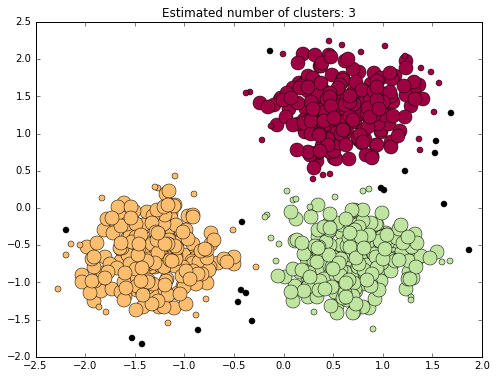

In [5]:
# 官網範例, 套進去DBSCAN之前有用 StandardScaler 套件作normalize
# 公式为：(X-mean)/std  檢調平均值後再除以標準差。
# 得到的结果是，对于每个属性所有数据都聚集在0附近，標準差=1。

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

##############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)
print(X)
X = StandardScaler().fit_transform(X)

##############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

##############################################################################
# Plot result
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [5]:
# 看標準化過後的平均距離是多少, 上述範例ep用0.3
distanceAry = []
for i, tp in enumerate(X):
    for j, otherP in enumerate(X[i + 1:]):
        distanceAry.append(np.linalg.norm(tp - otherP))
np.mean(sorted(distanceAry))

1.7626315885724004